In [ ]:
# tensorflow
# dl - LSTM
# data collect,process, basic Data engineering principles
# GenAI

In [ ]:
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.5 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=45f11559c05a51d5cf1c382db0303e7ee819252f2e594e446ac9c6c2f616470e
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [ ]:
# libraries
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
# data preprocessing
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
#AI
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

#graphics
import matplotlib.pyplot as plt

In [ ]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
# load data
init_data = yf.get_data(STOCK, start_date= date_3_years_back,end_date = date_now,interval = '1d')

In [ ]:
init_data.head(5)

,open,high,low,close,adjclose,volume,ticker
2021-05-12,111.309502,112.399002,109.681000,110.012497,110.012497,46376000,GOOGL
2021-05-13,111.306000,111.972000,110.335999,111.452003,111.452003,33204000,GOOGL
2021-05-14,112.927002,114.236000,112.500000,113.918999,113.918999,31996000,GOOGL
2021-05-17,113.178497,114.488998,112.775497,114.445999,114.445999,21598000,GOOGL
2021-05-18,115.117500,115.384003,113.109497,113.123497,113.123497,22204000,GOOGL


In [ ]:
# remove columns which our neural network will not use
init_df = init_data.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [ ]:
init_df.head(5)

,close,date
2021-05-12,110.012497,2021-05-12
2021-05-13,111.452003,2021-05-13
2021-05-14,113.918999,2021-05-14
2021-05-17,114.445999,2021-05-17
2021-05-18,113.123497,2021-05-18


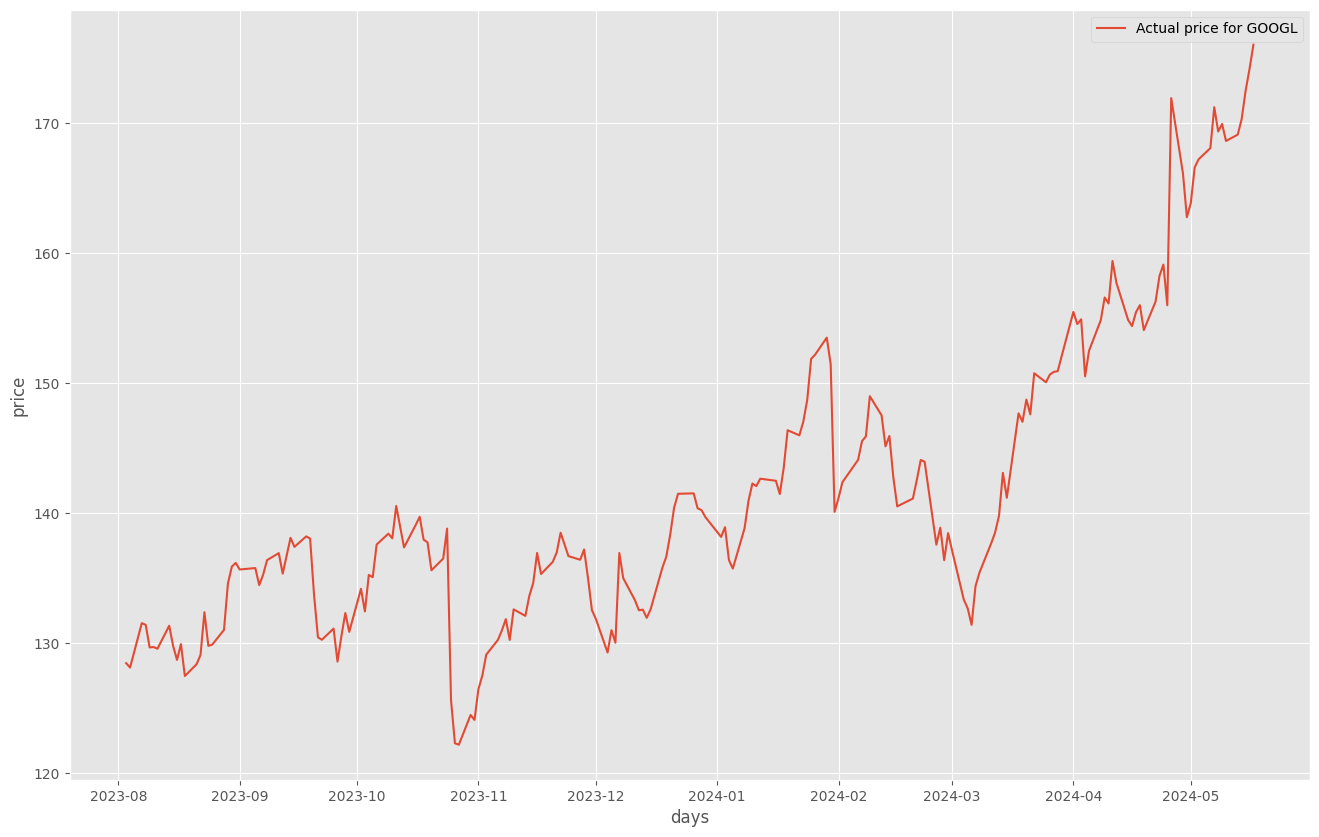

In [ ]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:
scalar = MinMaxScaler()
init_df['close']= scalar.fit_transform(np.expand_dims(init_df['close'].values,axis=1))

In [ ]:
init_df.head(5)

,close,date
2021-05-12,0.286975,2021-05-12
2021-05-13,0.302515,2021-05-13
2021-05-14,0.329148,2021-05-14
2021-05-17,0.334838,2021-05-17
2021-05-18,0.320560,2021-05-18


In [ ]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
        # ###########
          sequence_data.append([np.array(sequences), target])

# #######
  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
df, l, x, y = PrepareData(3)
print(df.head(4))
print("\n")
print(l[:1])
print("\n")
print(x[:1])
print("\n")
print(y[:1])

               close       date    future
2021-05-12  0.286975 2021-05-12  0.334838
2021-05-13  0.302515 2021-05-13  0.320560
2021-05-14  0.329148 2021-05-14  0.325434
2021-05-17  0.334838 2021-05-17  0.344570


[[0.9140668]]


[[[0.28697503434380744 Timestamp('2021-05-12 00:00:00')]
  [0.3025154270183693 Timestamp('2021-05-13 00:00:00')]
  [0.3291482167453149 Timestamp('2021-05-14 00:00:00')]
  [0.3348375230485884 Timestamp('2021-05-17 00:00:00')]
  [0.32056026756500733 Timestamp('2021-05-18 00:00:00')]
  [0.3254344978613727 Timestamp('2021-05-19 00:00:00')]
  [0.34456984026042237 Timestamp('2021-05-20 00:00:00')]]]


[0.37475442]


In [ ]:
def getModel(x_train,y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120,return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  batch_size = 8
  epochs = 80

  model.compile(loss='mean_squared_error',optimizer='adam')

  model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,
            verbose=1)

  model.summary()

  return model

In [ ]:
predictions = []

for step in LOOKUP_STEPS:
  df1,last_seq,x_train,y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = getModel(x_train,y_train)

  last_sequence = last_seq[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scalar.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 5s 14ms/step - loss: 0.0132
Epoch 2/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0039
Epoch 3/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0034
Epoch 4/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0037
Epoch 5/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0030
Epoch 6/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0034
Epoch 7/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0026
Epoch 8/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 9/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0027
Epoch 10/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0025
Epoch 11/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 12/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 13/80
95/95 [========================

In [ ]:
prediction = ', '.join([str(pred) for pred in predictions])
print(prediction)

175.47


24/24 [==============================] - 0s 5ms/step


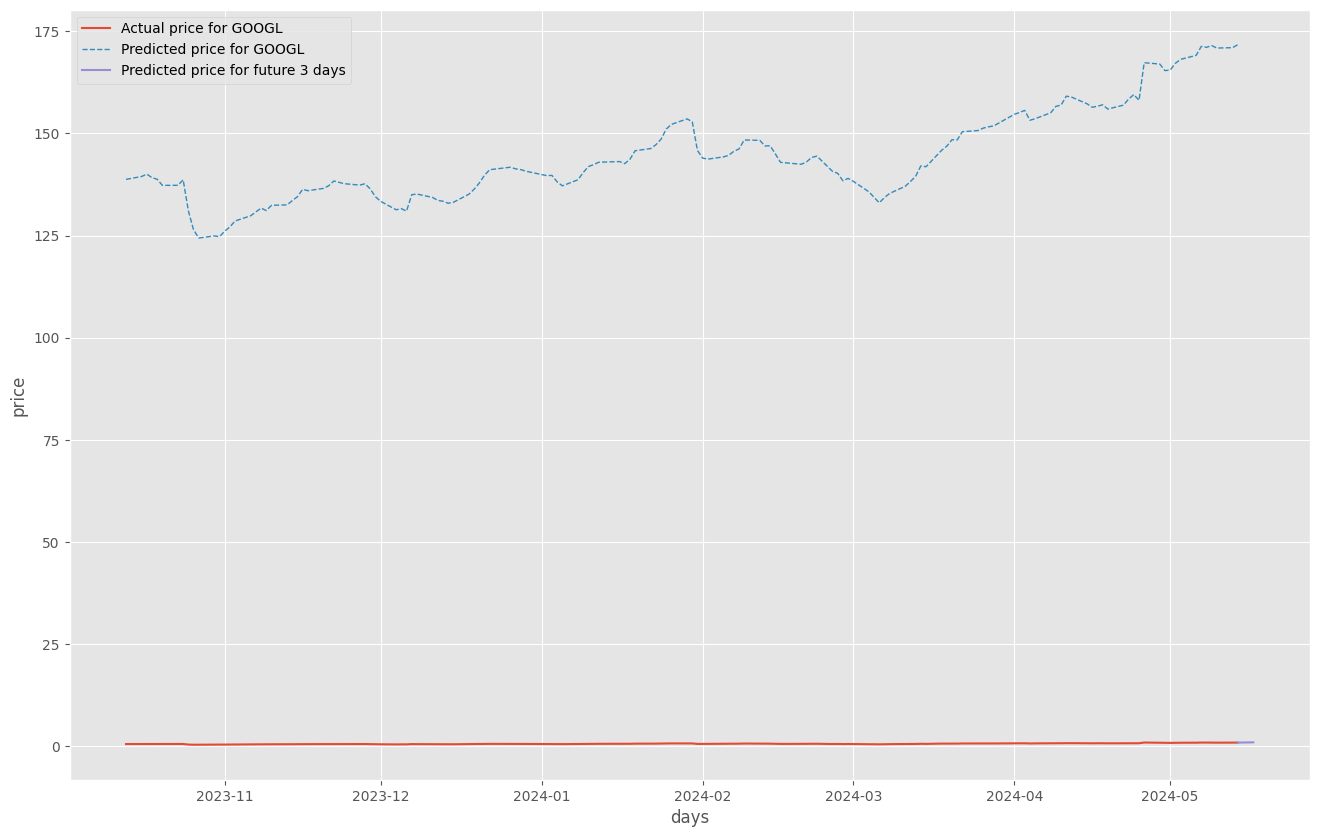

In [ ]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scalar.inverse_transform(y_predicted))
first_seq = scalar.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scalar.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

# copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
# copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
# copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

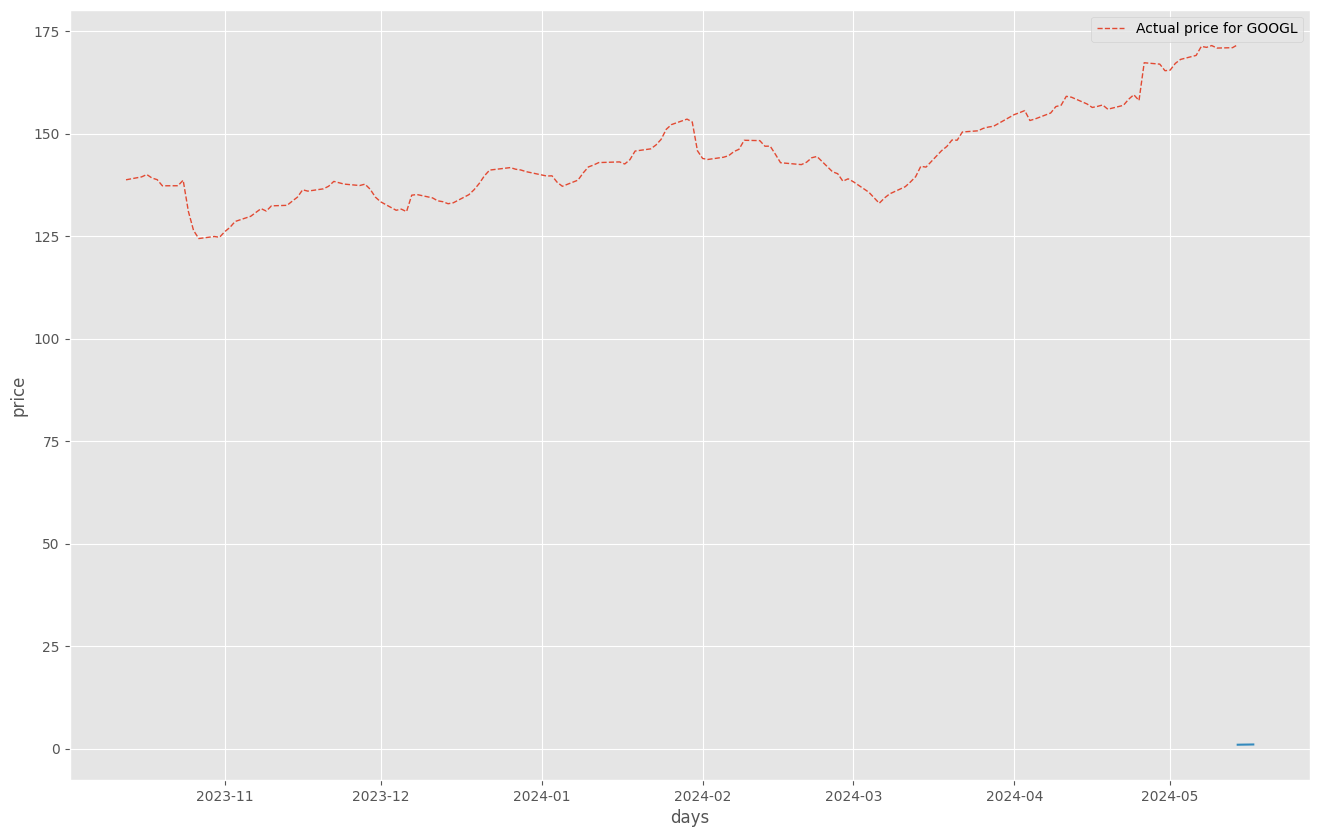

In [ ]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

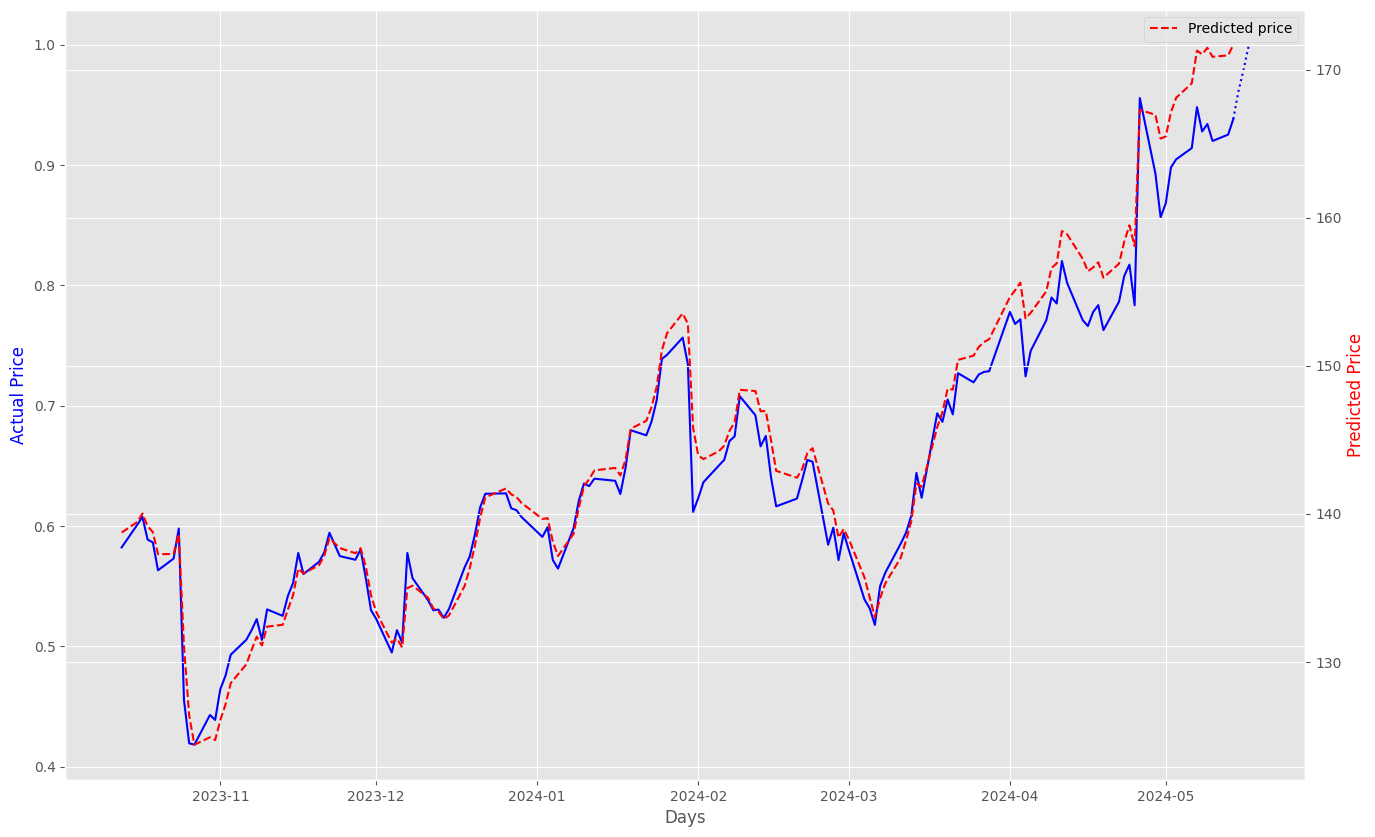

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot the 'close' column on the primary y-axis
ax1.plot(copy_df['close'][-150:].head(147), color='blue', label=f'Actual price for {STOCK}')
ax1.plot(copy_df['close'][-150:].tail(4), color='blue', linestyle='dotted')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the 'predicted_close' column on the secondary y-axis
ax2.plot(copy_df['predicted_close'][-150:].head(147), color='red', label='Predicted price', linestyle='dashed')

# Set labels and legend
ax1.set_xlabel("Days")
ax1.set_ylabel("Actual Price", color='blue')
ax2.set_ylabel("Predicted Price", color='red')
plt.legend()

# Show plot
plt.show()
